## A - Importing Libraries

In [1]:
!pip install gymnasium tensorflow tensorflow-metal matplotlib ale-py "numpy==1.23.5"

In [2]:
import gymnasium as gym
import random
import numpy as np
from matplotlib import style
from  matplotlib import pylab
from collections import deque
import matplotlib.pyplot as plt
import ale_py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Input, Dropout, Reshape, Softmax
from tensorflow.keras.optimizers import Adam
%matplotlib inline

#### Plot configuration

In [3]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,6)
load_model = False 

gym.register_envs(ale_py)

## B - Creating Agent Class

    All classes that needs to be created are created in one class.

In [4]:
class Agent():
    def __init__(self, epsilon_decay, epsilon_min,
                       gamma, learning_rate, state_size, action_size,
                       batch_size, training_threshold, update_target_frequency,
                       # --- Categorical DQN parameters ---
                       num_atoms=51, v_min=-10.0, v_max=10.0):
        '''CREATING AND DEFINING BASIC PARAMETERS FOR TRAINING'''
        self.movement_penalty = -1
        # Epsilon Greedy
        self.epsilon = 1.0 # Start epsilon at 1 for new training
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        # Discount factor
        self.gamma = gamma
        self.learning_rate = learning_rate
        # Environment dimensions
        self.state_size = state_size
        self.action_size = action_size
        # Training hyperparams
        self.batch_size = batch_size
        self.training_threshold = training_threshold
        self.update_target_frequency = update_target_frequency

        # --- Categorical DQN specific attributes ---
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max
        # Calculate atom values (support) and spacing
        self.z = np.linspace(self.v_min, self.v_max, self.num_atoms) # Atom values
        self.delta_z = (self.v_max - self.v_min) / (self.num_atoms - 1) # Distance between atoms
        # -----------------------------------------

         # Main Model (predicts and learns distributions)
        self.model = self.create_model()

         # Target Model (predicts target distributions)
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # Counter for updating the target network
        self.target_update_counter = 0

        # Replay Memory
        # Consider larger replay memory for more complex problems
        self.replay_memory = deque(maxlen=50000)

        if load_model:
            try:
                # Make sure the path is correct and matches the new model architecture
                self.model.load_weights("./Categorical_DDQN_PACMAN.weights.h5") # Use a new file name
                self.target_model.set_weights(self.model.get_weights()) # Sync target model on load
                print("Model weights loaded successfully.")
                # Adjust epsilon if loading a trained model
                self.epsilon = self.epsilon_min # Example: start greedy if loaded
            except Exception as e:
                print(f"Error loading model weights: {e}. Starting from scratch.")


    def update_replay_memory(self, state, action, reward, next_state, done):
        '''UPDATING REPLAY MEMORY'''
        # Store experiences in replay memory
        self.replay_memory.append((state, action, reward, next_state, done))
        # Note: Epsilon decay is often done after a training step or episode end

    def create_model(self):
        '''CREATING THE CATEGORICAL NEURAL NETWORK'''
        model = Sequential()
        model.add(Input(shape=(self.state_size,)))
        model.add(Dense(128, activation="relu"))
        model.add(Dropout(0.4))
        model.add(Dense(128, activation="relu"))
        model.add(Dropout(0.2))
        model.add(Dense(128, activation="relu")) # Last shared layer

        # Output layer produces logits for each atom for each action
        # Shape: (batch_size, action_size * num_atoms)
        model.add(Dense(self.action_size * self.num_atoms))

        # Reshape to (batch_size, action_size, num_atoms) to apply Softmax per action
        model.add(Reshape((self.action_size, self.num_atoms)))

        # Apply Softmax activation across the atoms dimension (axis=2) for each action
        model.add(Softmax(axis=2))

        # Compile using categorical cross-entropy
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='categorical_crossentropy')
        # model.summary() # Optional: print model structure
        return model

    def select_action(self, state):
        '''DEFINING EPSILON GREEDY STRATEGY based on EXPECTED Q-value'''
        # Reshape state if necessary
        if state.ndim == 1:
            state = np.reshape(state, [1, self.state_size])

        if np.random.rand() > self.epsilon:
            # Predict probability distributions for all actions
            # Output shape: (1, action_size, num_atoms)
            action_dist = self.model.predict(state, verbose=0)[0] # Get the distribution for the single state

            # Calculate expected Q-value for each action
            # Q(s,a) = Σ [ p(s,a,zᵢ) * zᵢ ]
            expected_q_values = np.sum(action_dist * self.z, axis=1) # Sum over atoms dimension

            # Choose action with highest expected Q-value
            return np.argmax(expected_q_values)
        else:
            # Explore: choose a random action
            return np.random.randint(0, self.action_size)

    def train_agent(self):
        '''TRAINING AGENT using Categorical Double DQN'''
        if len(self.replay_memory) < self.training_threshold:
            return None # Not enough samples to train yet

        # Sample a minibatch from replay memory
        batch_size = min(self.batch_size, len(self.replay_memory))
        minibatch = random.sample(self.replay_memory, batch_size)

        observations = np.zeros((batch_size, self.state_size))                    
        next_observations = np.zeros((batch_size, self.state_size))

        actions = []
        rewards = [] 
        dones = []
        
        for sample_index in range(self.batch_size):
            observations[sample_index] = minibatch[sample_index][0]                       
            actions.append(minibatch[sample_index][1])
            rewards.append(minibatch[sample_index][2])
            next_observations[sample_index] = minibatch[sample_index][3]
            dones.append(minibatch[sample_index][4])

        # --- Categorical Double DQN Update ---
        # 1. Predict distributions for next_observations with BOTH models
        # Output shape: (batch_size, action_size, num_atoms)
        next_dist_main = self.model.predict(next_observations, verbose=0)
        next_dist_target = self.target_model.predict(next_observations, verbose=0)

        # 2. Calculate expected Q-values for next_observations using MAIN model's distributions
        # Used to select the best next action (Double DQN part)
        next_q_main = np.sum(next_dist_main * self.z, axis=2) # Shape: (batch_size, action_size)

        # 3. Select best next actions 'a_prime' using MAIN model's Q-values
        action_primes = np.argmax(next_q_main, axis=1) # Shape: (batch_size,)

        # 4. Prepare target distribution array
        # This will hold the projected distributions for the actions actually taken
        target_distributions = np.zeros((batch_size, self.num_atoms)) # Shape: (batch_size, num_atoms)

        # 5. Calculate target distributions for each sample in the batch
        for i in range(batch_size):
            if dones[i]:
                # If terminal state, target distribution is centered on the reward
                Tz = np.clip(rewards[i], self.v_min, self.v_max) # Clip reward to be within support
                bj = (Tz - self.v_min) / self.delta_z # Calculate index in support
                l, u = np.floor(bj).astype(int), np.ceil(bj).astype(int)
                # Distribute probability 1 to closest atoms
                if l == u: # If Tz falls exactly on an atom
                    target_distributions[i, l] = 1.0
                else: # Distribute linearly
                    target_distributions[i, l] = (u - bj)
                    target_distributions[i, u] = (bj - l)
            else:
                # If not terminal, project the TARGET model's distribution for action_prime
                dist_target_prime = next_dist_target[i, action_primes[i], :] # Distribution for best next action from target net

                # Project each atom: Tz = r + gamma * z_j
                for j in range(self.num_atoms):
                    Tz_j = rewards[i] + self.gamma * self.z[j]
                    Tz_j = np.clip(Tz_j, self.v_min, self.v_max) # Clip projected value
                    bj = (Tz_j - self.v_min) / self.delta_z # Calculate index in support
                    l, u = np.floor(bj).astype(int), np.ceil(bj).astype(int)

                    # Distribute probability p_j from target distribution onto atoms l and u
                    prob_j = dist_target_prime[j]
                    if l == u: # If Tz_j falls exactly on an atom
                         target_distributions[i, l] += prob_j
                    else: # Distribute linearly
                        target_distributions[i, l] += prob_j * (u - bj)
                        target_distributions[i, u] += prob_j * (bj - l)

        # Ensure target distributions sum to 1 (handle potential floating point inaccuracies)
        target_distributions /= np.sum(target_distributions, axis=1, keepdims=True)
        # Replace nan that may occur from division by zero if a distribution sums to zero (shouldn't happen with correct projection)
        target_distributions = np.nan_to_num(target_distributions)


        # 6. Train the main model
        # We need to provide the target distributions ONLY for the actions that were taken.
        # Keras's categorical_crossentropy expects the target to have the same shape as the output.
        # We create a target tensor of shape (batch_size, action_size, num_atoms)
        # where only the slice corresponding to the action taken contains the calculated target distribution.

        # Get current predictions to use as a base (for actions not taken)
        # Alternatively, use zeros, as loss is calculated only for the action taken usually.
        # Using zeros might be safer and simpler depending on Keras backend details.
        labels = np.zeros_like(next_dist_main) # Shape: (batch_size, action_size, num_atoms)

        # Assign the calculated target distributions to the actions taken
        # This uses integer array indexing
        labels[np.arange(batch_size), actions, :] = target_distributions

        # Train the main model
        self.model.fit(observations, labels, batch_size=batch_size, verbose=0)

        # --- Target Network Update ---
        self.target_update_counter += 1
        if self.target_update_counter >= self.update_target_frequency:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

        # --- Epsilon Decay ---
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## C - Setting Hyperparameters

In [5]:
num_episodes= 2100                          
epsilon_decay = 0.999998                   
epsilon_min = 0.1                 
gamma = 0.99
learning_rate = 0.000001        
batch_size = 64
training_threshold = 1000 
update_target_every = 10
load_model = True                      

## D - Training Agent

2025-03-29 14:59:56.100538: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-29 14:59:56.100680: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-29 14:59:56.100685: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-29 14:59:56.100699: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-29 14:59:56.100710: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


Error loading model weights: [Errno 2] Unable to synchronously open file (unable to open file: name = './Categorical_DDQN_PACMAN.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Starting from scratch.
Episode: 0 -----Score: 200.0 -----Epsilon: 1.0
Saved model to disk
Episode: 1 -----Score: 240.0 -----Epsilon: 1.0


2025-03-29 14:59:56.865596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Episode: 2 -----Score: 300.0 -----Epsilon: 0.9991603518619643
Episode: 3 -----Score: 280.0 -----Epsilon: 0.9982115993077845


KeyboardInterrupt: 

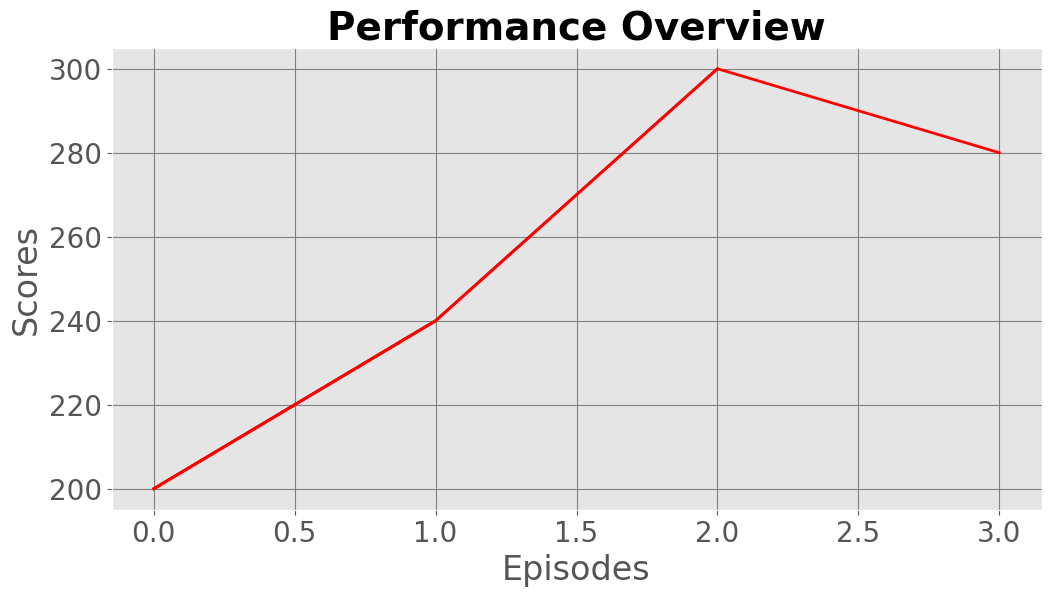

In [6]:
if __name__ == '__main__':
    with tf.device('/device:GPU:0'):
        
        env = gym.make('ALE/MsPacman-ram-v5')
        env.reset() 
        action_size = env.action_space.n
        state_size = env.observation_space.shape[0]
        agent = Agent(epsilon_decay, epsilon_min, 
                      gamma, learning_rate, state_size, 
                      action_size, batch_size, training_threshold,
                      update_target_every)

        scores = []
        eps_plot = []
        episodes = []
        rewards_lst = []

        for episode in range(num_episodes):
            done = False
            score = 0
            state = env.reset()
            state = np.reshape(state[0], [1, state_size])                                      
            lives = 3
            while not done:
                dead = False
                while not dead:
                    # env.render()
                    action = agent.select_action(state)
                    
                    next_state, reward, done, truncated, info = env.step(action)                       
                    next_state = np.reshape(next_state, [1, state_size])                    
                    
                    agent.update_replay_memory(state, action, reward, next_state, done)
                    agent.train_agent()
                    
                    state = next_state
                    score += reward
                    dead = info['lives']<lives
                    lives = info['lives']
                    
                    if dead:
                        reward = -100
                    else:
                        if reward ==0:
                            reward = agent.movement_penalty
                        else:
                            reward = reward
                            
                if done:
                    scores.append(score)
                    episodes.append(episode)
                    pylab.plot(episodes, scores, 'red', linewidth=2)
                    plt.xlabel("Episodes",size=24)
                    plt.ylabel("Scores",size=24)
                    plt.xticks(size=20)
                    plt.yticks(size=20)
                    pylab.title("Performance Overview",size=28,fontweight="bold")
                    plt.grid(True,color="gray")
                    pylab.savefig("final_version_v2.png")
                    
                    print("Episode:", episode, "-----Score:", score,"-----Epsilon:", agent.epsilon)

            if (episode % 25 == 0):
                agent.model.save_weights("./Deep Q-Learning - PACMAN/final_version_v2.weights.h5")
                print("Saved model to disk")

In [ ]:
scores

[240.0,
 200.0,
 440.0,
 250.0,
 580.0,
 170.0,
 240.0,
 140.0,
 410.0,
 380.0,
 290.0,
 200.0,
 250.0,
 400.0,
 260.0,
 230.0,
 250.0,
 470.0,
 270.0,
 200.0,
 160.0,
 250.0,
 200.0,
 350.0,
 180.0,
 290.0,
 180.0,
 190.0,
 140.0,
 260.0,
 290.0,
 380.0,
 270.0,
 330.0,
 380.0,
 290.0,
 170.0,
 280.0,
 320.0,
 340.0,
 290.0,
 340.0,
 430.0,
 260.0,
 200.0,
 210.0,
 240.0,
 500.0,
 150.0,
 240.0,
 210.0,
 320.0,
 290.0,
 260.0,
 450.0,
 240.0,
 390.0,
 190.0,
 420.0,
 200.0,
 640.0,
 230.0,
 390.0,
 180.0,
 300.0,
 350.0,
 330.0,
 360.0,
 250.0,
 130.0,
 510.0,
 310.0,
 240.0,
 330.0,
 250.0,
 210.0,
 310.0,
 190.0,
 530.0,
 190.0,
 280.0,
 220.0,
 1000.0,
 170.0,
 310.0,
 1210.0,
 210.0,
 330.0,
 350.0,
 250.0,
 1080.0,
 320.0,
 330.0,
 340.0,
 380.0,
 670.0,
 350.0,
 570.0,
 260.0,
 230.0,
 390.0,
 330.0,
 1300.0,
 320.0,
 150.0,
 200.0,
 350.0,
 250.0,
 470.0,
 180.0,
 220.0,
 260.0,
 140.0,
 320.0,
 240.0,
 310.0,
 270.0,
 290.0,
 240.0,
 350.0,
 240.0,
 200.0,
 370.0,
 110.0,
 950

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4766549743849499255
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 8566992741437710461
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


2025-03-29 14:54:26.983593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-29 14:54:26.983653: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
